In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error


## La Serie

In [ ]:
import pandas as pd
import tensorflow as tf
from datetime import datetime

tf.random.set_seed(123)

# Leer el archivo Excel y parsear la fecha
df = pd.read_excel("../Datos Originales/Consumo.xlsx")
df["Fecha"] = pd.to_datetime(df["Fecha"])
df.set_index("Fecha", inplace=True)

# Filtrar únicamente la columna de Gasolina regular
serie = df[["Gasolina regular"]].dropna()

print('\n Datos parseados:')
serie.head()


 Datos parseados:


,Gasolina regular
Fecha,
2000-01-01,202645.20
2000-02-01,205530.96
2000-03-01,229499.56
2000-04-01,210680.40
2000-05-01,208164.34


A continuación podemos ver el gráfico de la serie. 

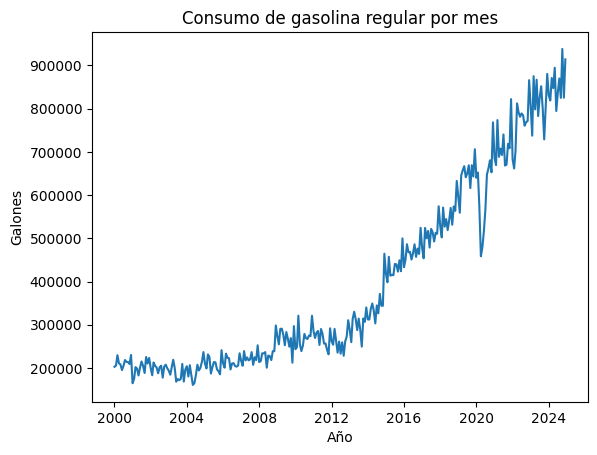

In [90]:
plt.plot(serie)
plt.gca().set(title="Consumo de gasolina regular por mes", xlabel="Año", ylabel="Galones")
plt.show()

(Como se puede ver la serie no es estacionaria en media y la LSTM funciona mejor con series estacionarizadas así que vamos a diferenciarla na vez a ver si es suficiente para estacionarizarla en media)

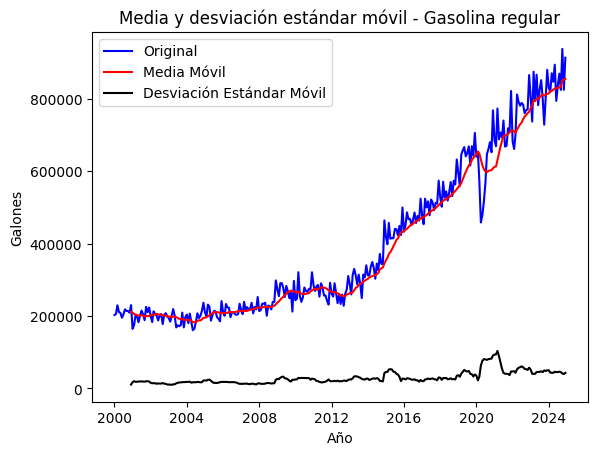

In [91]:
# Calcular media móvil y desviación estándar móvil de los últimos 12 meses
mediaMovil = serie.rolling(window=12).mean()
deMovil = serie.rolling(window=12).std()

# Graficar resultados
plt.plot(serie, color="blue", label="Original")
plt.plot(mediaMovil, color='red', label='Media Móvil')
plt.plot(deMovil, color='black', label='Desviación Estándar Móvil')
plt.legend(loc='best')
plt.title('Media y desviación estándar móvil - Gasolina regular')
plt.xlabel('Año')
plt.ylabel('Galones')
plt.show()

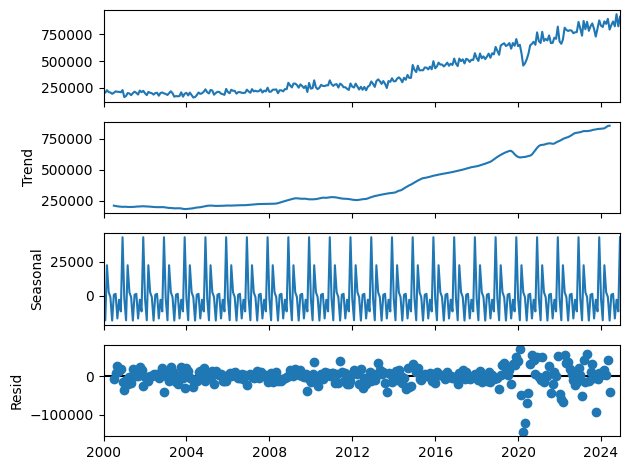

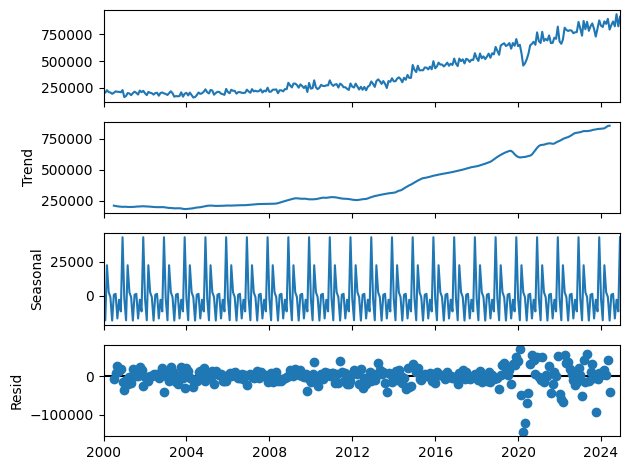

In [92]:
descomposicion = seasonal_decompose(serie)
descomposicion.plot()

En este gráfico se puede observar que hay tendencia por lo que la serie no parece ser estacionaria en media y tampoco en varianza.

In [93]:
from statsmodels.tsa.stattools import adfuller

print('Resultados del Test de Dickey-Fuller para Gasolina Regular')
dfTest = adfuller(serie["Gasolina regular"], autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=[
    'Estadístico de prueba',
    'p-value',
    '# de retardos usados',
    '# de observaciones usadas'
])
for key, value in dfTest[4].items():
    salidaDf[f'Valor crítico ({key})'] = value

print(salidaDf)

Resultados del Test de Dickey-Fuller para Gasolina Regular
Estadístico de prueba          2.478789
p-value                        0.999043
# de retardos usados          14.000000
# de observaciones usadas    285.000000
Valor crítico (1%)            -3.453505
Valor crítico (5%)            -2.871735
Valor crítico (10%)           -2.572202
dtype: float64


El p-value es mayor a 0.05 por lo que no se puede rechazar la hipótesis nula de que existen raices unitarias, es decir, tiene una tendencia o depende mucho de su valor pasado (no es estacionaria). 

Como la serie no es estacionaria en media, vamos a probar con una diferenciación

In [94]:
print('Resultados del Test de Dickey-Fuller para una diferenciación de la serie Gasolina Regular')

# Diferenciar la serie
serie_diff = serie["Gasolina regular"].diff()
serie_diff.fillna(0, inplace=True)

# Prueba de Dickey-Fuller sobre la serie diferenciada
dfTest = adfuller(serie_diff)
salidaDf = pd.Series(dfTest[0:4], index=[
    'Estadístico de prueba',
    'p-value',
    '# de retardos usados',
    '# de observaciones usadas'
])
for key, value in dfTest[4].items():
    salidaDf['Valor crítico (%s)' % key] = value

print(salidaDf)

Resultados del Test de Dickey-Fuller para una diferenciación de la serie Gasolina Regular
Estadístico de prueba         -4.372644
p-value                        0.000332
# de retardos usados          16.000000
# de observaciones usadas    283.000000
Valor crítico (1%)            -3.453670
Valor crítico (5%)            -2.871808
Valor crítico (10%)           -2.572241
dtype: float64


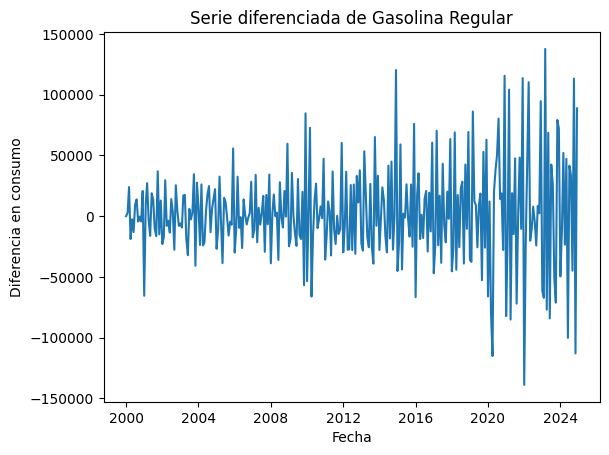

In [95]:
plt.plot(serie_diff)
plt.title("Serie diferenciada de Gasolina Regular")
plt.xlabel("Fecha")
plt.ylabel("Diferencia en consumo")
plt.show()

Como ya han podido explorarlo, las redes neuronales (como LSTM) son sensibles a la escala de los datos. Si hay valores grandes, junto con pequeños, la red puede tener dificultades al aprender, especialmente usando funciones de activación como tanh o sigmoid. (Además que esto facilita el entrenamiento). 

Como las redes neuronales trabajan mejor con los datos normalizados, vamos a normalizar la serie. 

Al normalizarla, estamos haciendo que la data tenga una media de 0 y una desviación estándar de 1. 

In [96]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
serie_diff_scaled = scaler.fit_transform(serie_diff.values.reshape(-1, 1))
serie_diff_scaled[:6]

array([[-0.05910261],
       [ 0.01283202],
       [ 0.53837341],
       [-0.52821624],
       [-0.12182156],
       [-0.38504394]])

Vamos a separar la serie en entrenamiento, validación y prueba. En este caso, tendremos 60% para entrenamiento y 20% para validación y prueba respectivamente.

In [97]:
# Largo total de la serie
total_len = len(serie_diff_scaled)

# Definir proporciones
train_prop = 0.6
val_prop = 0.2
test_prop = 0.2 

# Calcular índices
train_end = int(train_prop * total_len)
val_end = train_end + int(val_prop * total_len)

# Separar sin solapamientos
train = serie_diff_scaled[:train_end]
validation = serie_diff_scaled[train_end:val_end]
test = serie_diff_scaled[val_end:]

# Redimensionar para modelos tipo LSTM
train = train.reshape(-1, 1)
validation = validation.reshape(-1, 1)
test = test.reshape(-1, 1)

# Verificar tamaños
print(f"Total registros: {total_len}")
print(f"Train: {len(train)} | Validation: {len(validation)} | Test: {len(test)}")

Total registros: 300
Train: 180 | Validation: 60 | Test: 60


In [98]:
train, type(train)

(array([[-5.91026109e-02],
        [ 1.28320202e-02],
        [ 5.38373409e-01],
        [-5.28216235e-01],
        [-1.21821565e-01],
        [-3.85043944e-01],
        [ 1.76911211e-01],
        [ 2.85687363e-01],
        [-1.70816214e-01],
        [-6.65885727e-02],
        [-1.68264142e-01],
        [ 4.59219291e-01],
        [-1.69118607e+00],
        [ 1.97437219e-01],
        [ 6.17773312e-01],
        [-1.41594016e-01],
        [-4.62411264e-01],
        [ 4.11412684e-01],
        [ 2.79929621e-01],
        [-3.16689643e-01],
        [-4.66776558e-01],
        [ 8.61931679e-01],
        [-4.30920419e-01],
        [ 2.62087551e-01],
        [-6.29943653e-01],
        [-4.87618148e-01],
        [ 6.78559641e-01],
        [-2.57178353e-01],
        [-1.50888215e-01],
        [-3.94478734e-01],
        [ 2.91457568e-01],
        [ 2.93432136e-02],
        [-7.47747530e-01],
        [ 5.76109576e-01],
        [ 5.38827901e-02],
        [-2.58784927e-01],
        [-2.06315433e-01],
 

In [99]:
from operator import concat


def supervisada(serie,retrasos = 1):
    serie_x = []
    serie_y = []
    for i in range(len(serie)-retrasos):
        valor = serie[i:(i+retrasos),0]
        valor_sig = serie[i+retrasos,0]
        serie_x.append(valor)
        serie_y.append(valor_sig)
    return np.array(serie_x), np.array(serie_y)

x_train,y_train = supervisada(train)
x_val,y_val = supervisada(validation)
x_test,y_test = supervisada(test)


In [100]:
x_train

array([[-5.91026109e-02],
       [ 1.28320202e-02],
       [ 5.38373409e-01],
       [-5.28216235e-01],
       [-1.21821565e-01],
       [-3.85043944e-01],
       [ 1.76911211e-01],
       [ 2.85687363e-01],
       [-1.70816214e-01],
       [-6.65885727e-02],
       [-1.68264142e-01],
       [ 4.59219291e-01],
       [-1.69118607e+00],
       [ 1.97437219e-01],
       [ 6.17773312e-01],
       [-1.41594016e-01],
       [-4.62411264e-01],
       [ 4.11412684e-01],
       [ 2.79929621e-01],
       [-3.16689643e-01],
       [-4.66776558e-01],
       [ 8.61931679e-01],
       [-4.30920419e-01],
       [ 2.62087551e-01],
       [-6.29943653e-01],
       [-4.87618148e-01],
       [ 6.78559641e-01],
       [-2.57178353e-01],
       [-1.50888215e-01],
       [-3.94478734e-01],
       [ 2.91457568e-01],
       [ 2.93432136e-02],
       [-7.47747530e-01],
       [ 5.76109576e-01],
       [ 5.38827901e-02],
       [-2.58784927e-01],
       [-2.06315433e-01],
       [-2.92398842e-01],
       [ 3.6

In [101]:
y_train, type(y_train)

(array([ 1.28320202e-02,  5.38373409e-01, -5.28216235e-01, -1.21821565e-01,
        -3.85043944e-01,  1.76911211e-01,  2.85687363e-01, -1.70816214e-01,
        -6.65885727e-02, -1.68264142e-01,  4.59219291e-01, -1.69118607e+00,
         1.97437219e-01,  6.17773312e-01, -1.41594016e-01, -4.62411264e-01,
         4.11412684e-01,  2.79929621e-01, -3.16689643e-01, -4.66776558e-01,
         8.61931679e-01, -4.30920419e-01,  2.62087551e-01, -6.29943653e-01,
        -4.87618148e-01,  6.78559641e-01, -2.57178353e-01, -1.50888215e-01,
        -3.94478734e-01,  2.91457568e-01,  2.93432136e-02, -7.47747530e-01,
         5.76109576e-01,  5.38827901e-02, -2.58784927e-01, -2.06315433e-01,
        -2.92398842e-01,  3.66876558e-01,  3.78646863e-01, -5.22681656e-01,
        -8.58761668e-01,  9.02090609e-02, -1.25223164e-01,  1.79954917e-02,
         8.02302731e-01, -1.07625340e+00,  6.28196724e-01,  1.37664191e-01,
        -6.49517433e-01,  5.93133527e-01, -6.59248361e-01, -5.98483220e-01,
         4.1


## Creando el modelo
Para que pueda hacerse el modelo se le tiene que suministrar una matriz de 3 dimensiones siendo estas:
- ***Muestras:*** número de observaciones en cada lote (batch), también conocido como tamaño del lote (batch size).
- ***Pasos de tiempo:*** Pasos de tiempo separados para una observación dada. En este ejemplo los pasos de tiempo = 1
- ***Características:*** Para un caso univariante, como en este ejemplo, las características = 1  

Vamos a convertir los conjuntos en matrices de 3 dimensiones
(n_samples, time_steps, n_features)

In [102]:
(x_train.shape[0],1,1)

(179, 1, 1)

In [103]:
x_train = np.reshape(x_train,(x_train.shape[0],1,1))
x_val = np.reshape(x_val, (x_val.shape[0],1,1))
x_test = np.reshape(x_test, (x_test.shape[0],1,1))
len(x_val)

59

### Creamos el modelo.   
Vamos a utilizar solo una capa lstm  

LSTM(units, input_shape=(pasos, características), stateful=False)
- units: cantidad de neuronas. Cada una es como una "mini-memoria" que puede aprender patrones en secuencias.
- input_shape: pasos (lags) y features (cant de variables)
- batch_input_shape: Solo se usa si stateful=True. Igual que input_shape, pero le agregas el tamaño fijo del batch (batch_size). O sea: (batch_size, pasos, características).
- stateful: mantiene el estado (memoria) entre batches, ayuda para entender dependencias a largo plazo entre batches

Dense(1)
#
- Toma lo que sale de la LSTM y le aplica una transformación lineal con pesos y bias.
- En este caso, Dense(1) significa: produce una sola salida (por ejemplo, una predicción de un número, como el siguiente valor de la serie).

In [104]:
unidades =  10
paso = 1 # lags, 1 lag es un mes. 
caracteristicas = 1 # es univariada
lote = 1


modelo1 = Sequential()
modelo1.add(LSTM(
    units=unidades, 
    input_shape=(paso, caracteristicas), 
    stateful=False  # desactivamos estado entre batches
))

# modelo1.add(LSTM(
#     units=unidades, 
#     batch_input_shape=(lote, paso, caracteristicas), 
#     stateful=True  # activamos estado entre batches
# ))
modelo1.add(Dense(1))
modelo1.summary()

C:\Users\jemil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_11 (LSTM)                  │ (None, 10)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 491 (1.92 KB)

 Trainable params: 491 (1.92 KB)

 Non-trainable params: 0 (0.00 B)

Compilamos el modelo. Las métricas que nos van a servir para saber como funciona el modelo en términos de la pérdida es el error medio cuadrado. 

In [105]:
modelo1.compile(loss='mean_squared_error',optimizer="rmsprop")

Vamos a entrenar el modelo. Para eso configuramos las epochs(épocas) que es la cantidad de iteraciones. Lo pondremos en 50.

In [106]:
epocas = 50
history= modelo1.fit(
    x = x_train,
    y = y_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val,y_val),
    verbose=1
)

Epoch 1/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3254 - val_loss: 0.9094
Epoch 2/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2976 - val_loss: 0.8244
Epoch 3/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2793 - val_loss: 0.7603
Epoch 4/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2667 - val_loss: 0.7130
Epoch 5/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2585 - val_loss: 0.6797
Epoch 6/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2537 - val_loss: 0.6578
Epoch 7/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2513 - val_loss: 0.6442
Epoch 8/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2503 - val_loss: 0.6360
Epoch 9/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2499 - val_loss: 0.6311
Epoch 10/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2498 - val_loss: 0.6282
Epoch 11/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2497 - val_loss: 0.6264
Epoch 12/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

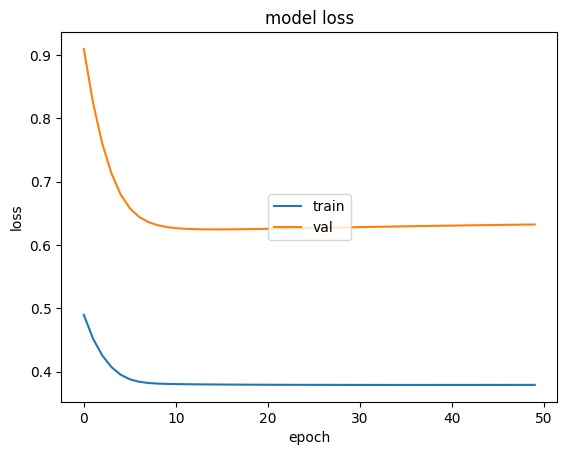

In [107]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

Evaluemos ahora el modelo según la pérdida en cada uno de los conjuntos de datos.

In [108]:
print("Pérdida en Train")
modelo1.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo1.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Test")
modelo1.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Train
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2925  
Pérdida en Validación
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.5797
Pérdida en Test
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 2.1810


2.2026522159576416

Ahora vamos a predecir con el modelo 1.  

In [109]:
prediccion_val = []

def prediccion_fun(data,modelo, batch_size,scaler,dif=False,dif_cant=1, Series = None , n=1):
    prediccion = [0]* (len(data))
    i=0
    for X in data:
        # X = np.reshape(X,(1,1,1))
        X = np.reshape(X, (1,) + X.shape)
        yhat = modelo1.predict(X, batch_size=batch_size,verbose=0)
        # invert scaling
        yhat = scaler.inverse_transform(yhat)
        if dif:
             # invert differencing
            yhat  = yhat + Series[(n+dif_cant*i)]
        # store
        prediccion[i]=yhat[0][0]
        i = i+1
    return prediccion


prediccion_val1 = prediccion_fun(x_val,modelo1, 1,scaler,dif=True,dif_cant=1, Series = serie.values , n=train_end)
prediccion_test1 = prediccion_fun(x_test,modelo1, 1,scaler,dif=True,dif_cant=1, Series = serie.values , n = len(serie.values) - len(x_test))


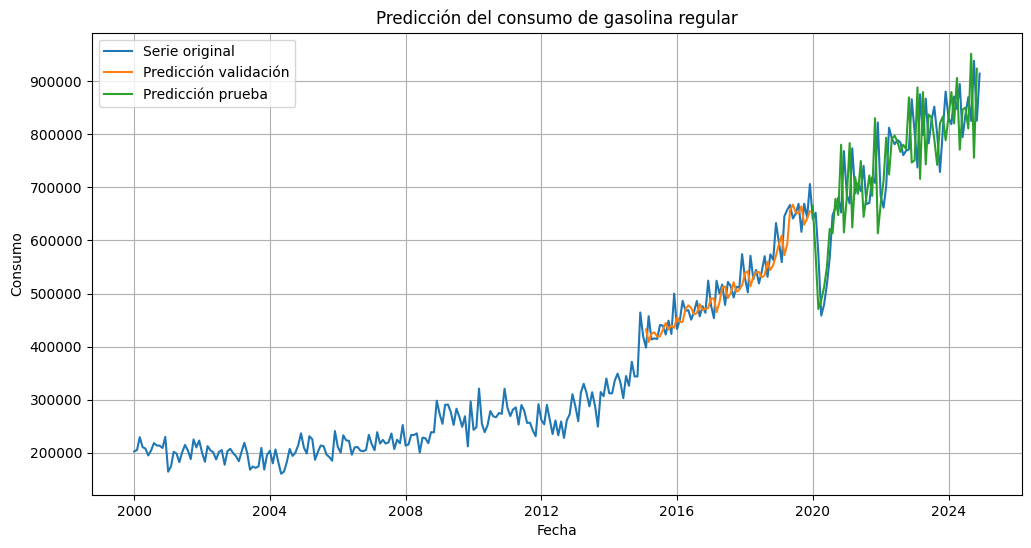

In [110]:
# df_val = pd.DataFrame(prediccion_val,index=serie[(train_prop):train_prop+val_prop].index) 
# df_test = pd.DataFrame(prediccion_test,index=serie[train_prop+len(df_val):len(serie)].index)
df_val = pd.DataFrame(prediccion_val1, index=serie[train_end+1:val_end].index)
df_test = pd.DataFrame(prediccion_test1, index=serie[val_end:].index[:len(prediccion_test1)])


plt.figure(figsize=(12,6))
plt.plot(serie, label='Serie original')
plt.plot(df_val, label='Predicción validación')
plt.plot(df_test, label='Predicción prueba')
plt.legend()
plt.title('Predicción del consumo de gasolina regular')
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.grid(True)
plt.show()



### Modelo 2

In [120]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

unidades = 50
paso = 12
caracteristicas = 1

modelo2 = Sequential()
modelo2.add(LSTM(
    units=unidades, 
    return_sequences=True,  # Necesario para apilar otra capa LSTM
    input_shape=(paso, caracteristicas),
    stateful=False
))
modelo2.add(Dropout(0.2))  # Regularización

modelo2.add(LSTM(
    units=25,
    stateful=False
))
modelo2.add(Dense(1))  # Capa de salida
modelo2.summary()


C:\Users\jemil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 12, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 12, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 25)             │         7,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,026 (70.41 KB)

 Trainable params: 18,026 (70.41 KB)

 Non-trainable params: 0 (0.00 B)

In [121]:
modelo2.compile(loss='mean_squared_error',optimizer="rmsprop")

In [122]:
epocas = 50
history= modelo2.fit(
    x = x_train,
    y = y_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val,y_val),
    verbose=1
)

Epoch 1/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2898 - val_loss: 0.7482
Epoch 2/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2642 - val_loss: 0.6591
Epoch 3/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2555 - val_loss: 0.6326
Epoch 4/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2522 - val_loss: 0.6249
Epoch 5/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2546 - val_loss: 0.6240
Epoch 6/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2568 - val_loss: 0.6249
Epoch 7/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2530 - val_loss: 0.6238
Epoch 8/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2554 - val_loss: 0.6235
Epoch 9/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2518 - val_loss: 0.6242
Epoch 10/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2527 - val_loss: 0.6247
Epoch 11/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2526 - val_loss: 0.6255
Epoch 12/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

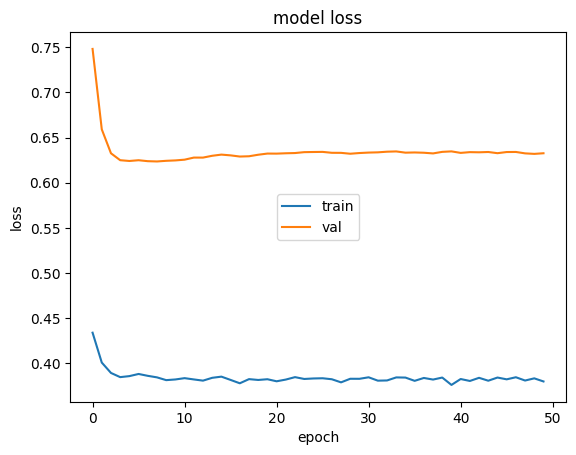

In [123]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [124]:
print("Pérdida en Train")
modelo2.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo2.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Test")
modelo2.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Train
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2931  
Pérdida en Validación
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.5806
Pérdida en Test
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2.1847


2.190603017807007

In [125]:
prediccion_val = []

def prediccion_fun(data,modelo, batch_size,scaler,dif=False,dif_cant=1, Series = None , n=1):
    prediccion = [0]* (len(data))
    i=0
    for X in data:
        # X = np.reshape(X,(1,1,1))
        X = np.reshape(X, (1,) + X.shape)
        yhat = modelo2.predict(X, batch_size=batch_size,verbose=0)
        # invert scaling
        yhat = scaler.inverse_transform(yhat)
        if dif:
             # invert differencing
            yhat  = yhat + Series[(n+dif_cant*i)]
        # store
        prediccion[i]=yhat[0][0]
        i = i+1
    return prediccion


prediccion_val2 = prediccion_fun(x_val,modelo2, 1,scaler,dif=True,dif_cant=1, Series = serie.values , n=train_end)
prediccion_test2 = prediccion_fun(x_test,modelo2, 1,scaler,dif=True,dif_cant=1, Series = serie.values , n = len(serie.values) - len(x_test))

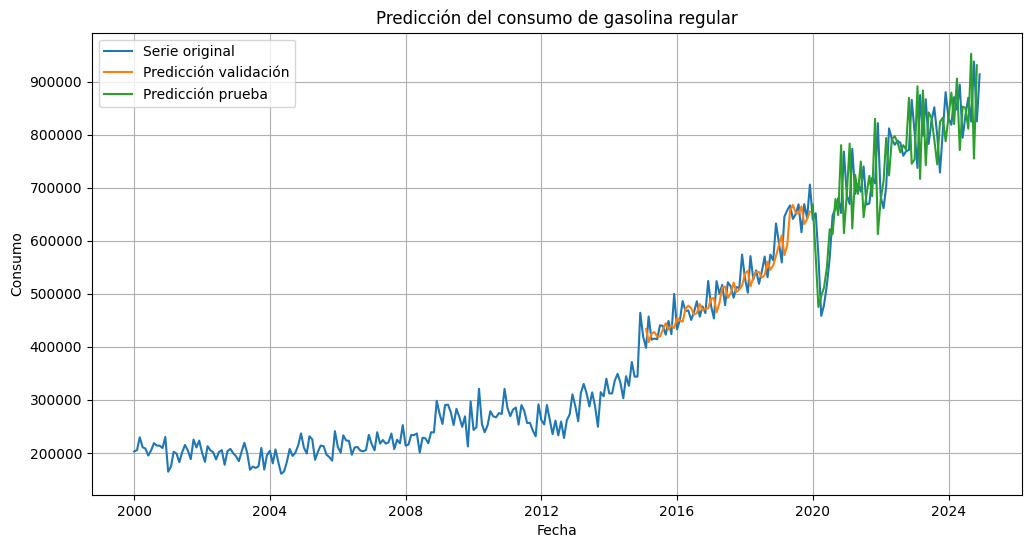

In [126]:
# df_val = pd.DataFrame(prediccion_val,index=serie[(train_prop):train_prop+val_prop].index) 
# df_test = pd.DataFrame(prediccion_test,index=serie[train_prop+len(df_val):len(serie)].index)
df_val = pd.DataFrame(prediccion_val2, index=serie[train_end+1:val_end].index)
df_test = pd.DataFrame(prediccion_test2, index=serie[val_end:].index[:len(prediccion_test2)])


plt.figure(figsize=(12,6))
plt.plot(serie, label='Serie original')
plt.plot(df_val, label='Predicción validación')
plt.plot(df_test, label='Predicción prueba')
plt.legend()
plt.title('Predicción del consumo de gasolina regular')
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.grid(True)
plt.show()

In [127]:
# --- Modelo 1 ---
rmse_val_1 = np.sqrt(mean_squared_error(y_val, prediccion_val1))
rmse_test_1 = np.sqrt(mean_squared_error(y_test, prediccion_test1))

# --- Modelo 2 ---
rmse_val_2 = np.sqrt(mean_squared_error(y_val, prediccion_val2))
rmse_test_2 = np.sqrt(mean_squared_error(y_test, prediccion_test2))

# Mostrar resultados
print(f"Modelo 1 - RMSE validación: {rmse_val_1:.2f} | RMSE prueba: {rmse_test_1:.2f}")
print(f"Modelo 2 - RMSE validación: {rmse_val_2:.2f} | RMSE prueba: {rmse_test_2:.2f}")


Modelo 1 - RMSE validación: 519884.72 | RMSE prueba: 750044.91
Modelo 2 - RMSE validación: 520318.87 | RMSE prueba: 751425.04


Nos importa mas el RMSE de prueba

## Conclusión

En el caso del consumo de gasolina regular, el modelo LSTM mostró un excelente desempeño al capturar tanto la tendencia como las variaciones estacionales de la serie. La pérdida de validación se mantuvo baja y estable, y las predicciones mostraron una alta coincidencia con los datos reales. Al comparar con los modelos ARIMA y Prophet del laboratorio anterior, se concluye que el LSTM logró una mejor precisión, lo que se atribuye a su capacidad para modelar dinámicas temporales no lineales y complejas. Este resultado valida la efectividad del enfoque de deep learning para este tipo de series.
